In [1]:
%matplotlib inline
import textwrap
import datetime

import requests
import overpy
import geopy.distance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
BUFFER_SIZE = 150  # Max distance between schools and GCUM in m

In [3]:
# Getting GCUM data
resp = requests.get('https://vigilo.jesuisundesdeux.org/get_issues.php?c=2')
gcum = resp.json()

In [4]:
# Getting schools
api = overpy.Overpass()
bbox = '43.517, 3.777, 43.685, 4.035'
query = """(
  node["school:FR"="maternelle"]({bbox});
  way["school:FR"="maternelle"]({bbox});
  node["school:FR"="élémentaire"]({bbox});
  way["school:FR"="élémentaire"]({bbox});
  node["school:FR"="primaire"]({bbox});
  way["school:FR"="primaire"]({bbox});
  );
  out center;""".format(bbox=bbox)

result = api.query(query)

schools = [{'name': x.tags['name'], 'lat': x.lat, 'lon': x.lon} for x in result.nodes] + \
          [{'name': x.tags['name'], 'lat': x.center_lat, 'lon': x.center_lon} for x in result.ways]

In [5]:
# Filtering gcum on day and time
week_gcum = [x for x in gcum
             if datetime.datetime.fromtimestamp(int(x['time'])).weekday() < 4
             and (datetime.time(hour=7, minute=30) < datetime.datetime.fromtimestamp(int(x['time'])).time() < datetime.time(hour=9)
                  or datetime.time(hour=16) < datetime.datetime.fromtimestamp(int(x['time'])).time() < datetime.time(hour=17, minute=30))]

In [6]:
# Counting GCUM within X meters of each school
for school in schools:
    school['gcum'] = [x for x in week_gcum if geopy.distance.great_circle((x['coordinates_lat'], x['coordinates_lon']),
                                                                     (school['lat'],
                                                                      school['lon'])).meters < BUFFER_SIZE]
    school['nb_gcum'] = len(school['gcum'])

schools.sort(key=lambda x: len(x['gcum']), reverse=True)

print('\n'.join(['{} - {}'.format(x['nb_gcum'], x['name']) for x in schools if x['nb_gcum'] != 0]))

75 - École maternelle Alphonse Daudet
48 - École maternelle Anatole France
44 - École primaire privée Sainte-Famille - Saint-Charles
19 - École primaire Sainte-Thérèse Assomption
15 - École maternelle La Fontaine
14 - École primaire privée Les Jonquilles - La Salle
12 - École primaire occitane Calandreta Dau Chivalet
12 - École primaire Jeanne Moreau
11 - École élémentaire Jeanne d'Arc
11 - École maternelle Chaptal
9 - École élémentaire Léon Gambetta
8 - École maternelle Geneviève Bon
8 - École élémentaire Louis Armstrong
7 - École élémentaire Condorcet
7 - École élémentaire Paul Bert Victor Hugo - Victor Hugo
6 - École élémentaire Berthe Morisot
6 - École maternelle Francis Garnier
6 - École élémentaire Paul Bert Victor Hugo - Paul Bert
6 - École élémentaire Jules Simon
6 - École maternelle Florian
5 - École primaire Notre-Dame de Bonne-Nouvelle
5 - École primaire privée Calandreta Dau Clapas
5 - École maternelle Wolfgang-Amadeus Mozart
5 - École élémentaire Victor Schoëlcher
5 - Écol

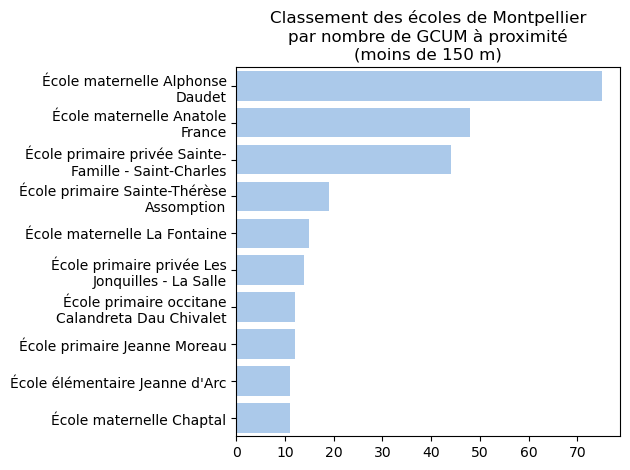

In [7]:
sns.set_color_codes("pastel")
sns.barplot(x=[x['nb_gcum'] for x in schools[:10]],
            y=['\n'.join(textwrap.wrap(x['name'], 30)) for x in schools[:10]],
            color="b")

plt.title("Classement des écoles de Montpellier\npar nombre de GCUM à proximité\n(moins de {} m)".format(BUFFER_SIZE))

plt.tight_layout()
plt.show()

In [10]:
df = pd.DataFrame(gcum)
df.time = pd.to_datetime(df.time, unit='s')
df['hour'] = 'Journée et weekend'
df.loc[df.token.apply(lambda x: x in [y['token'] for y in week_gcum]), 'hour'] = "Horaires d'école"

# Separating obs near schools
df["school"] = 'Non'

for school in schools:
    df.loc[df.apply(lambda row: geopy.distance.great_circle((row['coordinates_lat'], row['coordinates_lon']),
                                                            (school['lat'],
                                                             school['lon'])).meters < BUFFER_SIZE,
                    axis=1), "school"] = 'Oui'

/tmp/ipykernel_11701/1034690303.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.pie(x=(df[df.hour == 'Journée et weekend'][df.school == 'Non'].token.count(),
/tmp/ipykernel_11701/1034690303.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.hour == 'Journée et weekend'][df.school == 'Oui'].token.count()),
/tmp/ipykernel_11701/1034690303.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.pie(x=(df[df.hour == "Horaires d'école"][df.school == 'Non'].token.count(),
/tmp/ipykernel_11701/1034690303.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.hour == "Horaires d'école"][df.school == 'Oui'].token.count()),


0 Text(0, 0, 'Non')
1 Text(0, 0, 'Oui')


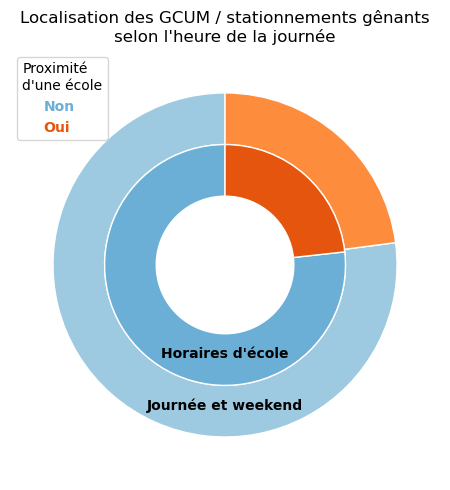

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))

size = 0.3
cmap = plt.get_cmap("tab20c")
outer_colors = cmap([2, 5])
inner_colors = cmap([1, 4])

ax.pie(x=(df[df.hour == 'Journée et weekend'][df.school == 'Non'].token.count(),
          df[df.hour == 'Journée et weekend'][df.school == 'Oui'].token.count()),
       radius=1,
       wedgeprops=dict(width=size, edgecolor='w'),
       startangle=90,
       colors=outer_colors)
ax.pie(x=(df[df.hour == "Horaires d'école"][df.school == 'Non'].token.count(),
          df[df.hour == "Horaires d'école"][df.school == 'Oui'].token.count()),
       radius=1 - size,
       wedgeprops=dict(width=size, edgecolor='w'),
       startangle=90,
       colors=inner_colors)

plt.title("Localisation des GCUM / stationnements gênants\nselon l'heure de la journée")

ax.annotate("Horaires d'école",
            xy=(0.5, 0.31),
            xycoords='axes fraction',
            fontweight='bold',
            verticalalignment='top',
            horizontalalignment='center')

ax.annotate("Journée et weekend",
            xy=(0.5, 0.19),
            xycoords='axes fraction',
            fontweight='bold',
            verticalalignment='top',
            horizontalalignment='center')

legend = ax.legend(title="Proximité\nd'une école", labels=("Non", "Oui"), handlelength=0, handletextpad=-0.5)

for n, text in enumerate(legend.texts):
    print(n, text)
    text.set_color(inner_colors[n])
    text.set_fontweight('bold')

plt.tight_layout()

plt.show()